In [118]:
%matplotlib inline

In [119]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

import scipy.ndimage as nd
import scipy.spatial

from stsci.convolve import convolve2d
from skimage.transform import warp
from skimage.transform import SimilarityTransform
from skimage.morphology import dilation
from skimage.morphology import binary_dilation

import astropy.io.fits as pyfits
import astropy.wcs as pywcs
import astropy.units as u

from photutils import create_matching_kernel
from photutils import (HanningWindow, TukeyWindow, CosineBellWindow,
                       SplitCosineBellWindow, TopHatWindow)

import drizzlepac
from drizzlepac.astrodrizzle import ablot

from grizli import utils

# Need to move these to public repo
from research.grizli import irac 
from research.grizli.process_irac import get_wcslist, _obj_shift

In [121]:
root = 'j142632p3508'

root = 'j025708m2326'

PATH = '/Users/gbrammer/Research/HST/CHArGE/IRAC/'+root
try:
    os.mkdir(PATH)
except:
    pass

os.chdir(PATH)

In [142]:
from grizli import ds9
ds9 = ds9.DS9()

In [124]:
# Windowing for PSF match
window = HanningWindow()

In [125]:
###############
# HST Images
ref_file = glob.glob('{0}-f1*_drz_sci.fits'.format(root)) 
ref_file += glob.glob('{0}-ir*sci.fits'.format(root))

ref_file.sort()
ref_file = ref_file[-1]

print(f'HST reference file: {ref_file}')

hst_im = pyfits.open(ref_file)
ref_filter = utils.get_hst_filter(hst_im[0].header).lower()
hst_wht = pyfits.open(ref_file.replace('_sci', '_wht'))
hst_psf = pyfits.open('{0}-{1}_psf.fits'.format(root, 'f160w'))[1].data

if os.path.exists('star_psf.fits'):
    st = pyfits.open('star_psf.fits')
    hst_psf = st['OPSF','F160W'].data*1

hst_psf /= hst_psf.sum()

hst_seg = pyfits.open(root+'-ir_seg.fits')[0]
hst_ujy = hst_im[0].data*hst_im[0].header['PHOTFNU'] * 1.e6
hst_wcs = pywcs.WCS(hst_im[0].header)

phot = utils.read_catalog('{0}_irac_phot.fits'.format(root))

#########################
# Watershed dilation of the segmentation maps to make regions larger
from skimage.morphology import watershed
from astropy.convolution.kernels import Gaussian2DKernel
kern = Gaussian2DKernel(5).array

med = np.median(hst_im[0].data[(hst_wht[0].data > 0) & (hst_seg.data == 0)])
hst_conv = convolve2d(hst_im[0].data-med, kern, fft=1)
hst_var = 1/hst_wht[0].data
wht_med = np.percentile(hst_wht[0].data[hst_wht[0].data > 0], 5)
hst_var[hst_wht[0].data < wht_med] = 1/wht_med
hst_cvar = convolve2d(hst_var, kern**2, fft=1)

xi = np.cast[int](np.round(phot['xpeak']))
yi = np.cast[int](np.round(phot['ypeak']))
markers = np.zeros(hst_im[0].data.shape, dtype=int)
markers[yi, xi] = phot['number']

waterseg = watershed(-hst_conv, markers, mask=(hst_conv/np.sqrt(hst_cvar) > 1))
waterseg[waterseg == 0] = hst_seg.data[waterseg == 0]

HST reference file: j025708m2326-ir_drz_sci.fits


In [143]:
if ds9 is not None:
    ds9.frame(1)
    ds9.set(f'file {ref_file}')
    ds9.set_defaults(match='wcs')
    ds9.frame(2)
    ds9.set(f'file {root}-ir_seg.fits')

In [221]:
# Spitzer channel to fit (integers for IRAC, 'mips1' for 24um)
ch = 2

In [222]:
################
# Parameters for IRAC fitting
USE_AVG_PSF=True
if USE_AVG_PSF:
    avg_psf = pyfits.open('{0}-ch{1}-0.1.psfr_avg.fits'.format(root, ch))[0].data
else:
    avg_psf=None

avg_kern = None #np.ones((5,5))
hst_psf_offset = [2,2]
hst_psf_size = hst_psf.shape[0]//2

# Masks around Bright stars 
try:
    _ = bright_limits
    bright_ids = None
except:
    bright_limits = [16,19]
    bright_ids = None

bright_sn = 3

###############
# Load Spitzer images
if ch == 'mips1':
    irac_im = pyfits.open('{0}-{1}_drz_sci.fits'.format(root, ch))[0]
    irac_wht = pyfits.open('{0}-{1}_drz_wht.fits'.format(root, ch))[0].data
    irac_psf_obj = irac.MipsPSF()
    pf = 10 # assume 1" pixels

    column_root = 'mips_24'
    phot['{0}_flux'.format(column_root)] = -99.
    phot['{0}_err'.format(column_root)] = -99.
    phot['{0}_bright'.format(column_root)] = 0

    bright_limits = None
    #ERR_SCALE = 0.1828 # From residuals
    ch_label = ch
    ERR_SCALE = 1.

else:
    irac_im = pyfits.open('{0}-ch{1}_drz_sci.fits'.format(root, ch))[0]
    irac_wht = pyfits.open('{0}-ch{1}_drz_wht.fits'.format(root, ch))[0].data
    irac_psf_obj = irac.IracPSF(ch=ch, scale=0.1, verbose=True, avg_psf=avg_psf)
    
    ERR_SCALE = 1.
    if os.path.exists('{0}-ch{1}.cat.fits'.format(root, ch)):
        ir_tab = utils.read_catalog('{0}-ch{1}.cat.fits'.format(root, ch))
        if 'ERR_SCALE' in ir_tab.meta:
            ERR_SCALE = ir_tab.meta['ERR_SCALE']
    
    # Integer ratio of pixel sizes between IRAC and HST
    try:
        irac_wcs = pywcs.WCS(irac_im.header)
        pscale = utils.get_wcs_pscale(irac_wcs)
        pf = int(np.round(pscale/0.1))
    except:
        pf = 5

    column_root = 'irac_ch{0}'.format(ch)        
    phot['{0}_flux'.format(column_root)] = -99.
    phot['{0}_err'.format(column_root)] = -99.
    phot['{0}_bright'.format(column_root)] = 0
    ch_label = 'ch{0}'.format(ch)

Read PSF data r37857024-ch2.log.fits / r37857024-ch2-0.1.psf.fits
Read PSF data r37857280-ch2.log.fits / r37857280-ch2-0.1.psf.fits
Use rotated `avg_psf`.


In [229]:
### (Restart from here after computing alignment below)

##################
# HST PSF in same dimensions as IRAC
tf=None
rd = hst_wcs.wcs.crval
_psf, _, _ = irac_psf_obj.evaluate_psf(ra=rd[0], dec=rd[1], 
                              min_count=1, clip_negative=True, 
                              transform=tf)

hst_psf_full = np.zeros_like(_psf)
sh_irac = hst_psf_full.shape
hslx = slice(sh_irac[0]//2+hst_psf_offset[0]-hst_psf_size, sh_irac[0]//2+hst_psf_offset[0]+hst_psf_size)
hsly = slice(sh_irac[0]//2+hst_psf_offset[1]-hst_psf_size, sh_irac[0]//2+hst_psf_offset[1]+hst_psf_size)
hst_psf_full[hsly, hslx] += hst_psf

# IRAC WCS
irac_wcs = pywcs.WCS(irac_im.header)

# not used
mx = my = None

# HST weight in IRAC frame
hst_wht_i = hst_wht[0].data[::pf, ::pf]
ll = np.cast[int](irac_wcs.all_world2pix(hst_wcs.all_pix2world(np.array([[-0.5, -0.5]]), 0), 0)).flatten()
irac_mask = np.zeros(irac_im.data.shape)
isly = slice(ll[1], ll[1]+hst_wht_i.shape[0])
islx = slice(ll[0], ll[0]+hst_wht_i.shape[1])
irac_wht[isly, islx] *= hst_wht_i > 0
irac_sivar = np.sqrt(irac_wht)/ERR_SCALE

tf = None

In [235]:
# Test at the center of the image as displayed in DS9

# Initial small patch
get_pan, patch_arcmin = True, 0.5

get_pan, patch_arcmin = True, 1.4

Npan = int(patch_arcmin*60*10/pf)
print(patch_arcmin, Npan)

1.4 168


In [236]:
##################################
##################################
# Big script to run the modeling

# Get the DS9 pan position
if get_pan:
    
    rd_pan = np.cast['float'](ds9.get('pan fk5').split())
    
    xy_irac = np.cast[int](np.round(irac_wcs.all_world2pix(np.array([rd_pan]), 0))).flatten()
    
    ll_irac = xy_irac-Npan
    ll_hst_raw = hst_wcs.all_world2pix(irac_wcs.all_pix2world(np.array([xy_irac-Npan])-0.5, 0), 0)
    ll_hst = np.cast[int](np.ceil(ll_hst_raw)).flatten()
    
    #Npan = 256
    slx = slice(ll_hst[0], ll_hst[0]+2*Npan*pf)
    sly = slice(ll_hst[1], ll_hst[1]+2*Npan*pf)

    if False:
        print('Dilate segmentation image')
        
        seg_sl = hst_seg.data[sly, slx]*1
        ids = np.unique(seg_sl)[1:]
        in_seg = utils.column_values_in_list(phot['number'], ids) & (phot['mag_auto'] < 26)
        in_seg &= np.isfinite(phot[ref_filter+'_fluxerr_aper_1'])
        in_seg &= phot[ref_filter+'_fluxerr_aper_1'] > 0
        
        so = np.argsort(phot['mag_auto'][in_seg])
        
        sizes = np.clip(np.cast[int](np.sqrt(phot['npix'])), 2, 64)
        so = np.argsort(sizes[in_seg])[::-1]
        
        for iter in range(3):
            for id, mag, si in zip(phot['number'][in_seg][so], phot['mag_auto'][in_seg][so], sizes[in_seg][so]):
                #break
                #si = np.clip(np.cast[int](1.8**(26-np.clip(mag, 18, 25))), 3, 32)
                print('{0} {1:.2f} {2}'.format(id, mag, si))
                seg_dilate = np.zeros((si, si))
                seg_dilate[si//2,:] = 1
                seg_dilate[:,si//2] = 1

                dil_id = binary_dilation(seg_sl == id, seg_dilate)
                seg_sl[(seg_sl == 0) & dil_id] = id
        
        ds9.frame(10)
        ds9.view(seg_sl, header=utils.to_header(hst_wcs.slice((sly, slx))))
    else:
        #seg_sl = hst_seg.data[sly, slx]*1
        seg_sl = waterseg[sly, slx]*1
        ds9.frame(10)
        ds9.view(seg_sl, header=utils.to_header(hst_wcs.slice((sly, slx))))

# What IDs are we fitting here?
ids = np.unique(seg_sl)[1:]
N = len(ids)

islx = slice(ll_irac[0], ll_irac[0]+2*Npan)
isly = slice(ll_irac[1], ll_irac[1]+2*Npan)

print('Compute object models (N={0})'.format(N))

# Generate position-specific PSF for each source
source_psf = True

if source_psf:
    # Evaluate PSF at each position
    _A = []
    hst_slice = hst_ujy[sly, slx]
    for i, id in enumerate(ids):
        print(i, id)
        ix = phot['number'] == id
        
        if mx is not None:
            rx_i = mx(phot['ra'][ix]-m0[0], phot['dec'][ix]-m0[1])
            ry_i = my(phot['ra'][ix]-m0[0], phot['dec'][ix]-m0[1])
            tf = np.array([rx_i, ry_i]) #{'translation':(rx_i, ry_i)}

        else:
            #tf = {'translation':(rx, ry)}
            tf = None
            
        _ = irac_psf_obj.evaluate_psf(ra=phot['ra'][ix], dec=phot['dec'][ix], min_count=0, 
                                      clip_negative=True, transform=tf)

        irac_psf, psf_exptime, psf_count = _                              
        if window is -1:
            psf_kernel = irac_psf
        else:
            psf_kernel = create_matching_kernel(hst_psf_full, irac_psf, window=window)

        # Extra factor for rebinning pixel grids, assuming 5x oversampling
        if avg_kern is not None:
            psf_kernel = convolve2d(psf_kernel, avg_kern, mode='constant', fft=1, cval=0.)
        else:
            psf_kernel *= pf**2
            
        _Ai = convolve2d(hst_slice*(seg_sl == id), psf_kernel,
                          mode='constant', fft=1)[::pf, ::pf].flatten()
        _A.append(_Ai)                 
    
    _A = np.array(_A)
        
else:
    try:
        _ = rd_pan
    except:
        rd_pan = hst_wcs.wcs.crval

    #if tf is None:
    #    tf = {'translation':(rx, ry)}
        
    _ = irac_psf_obj.evaluate_psf(ra=rd_pan[0], dec=rd_pan[1], 
                                  min_count=1, clip_negative=True, 
                                  transform=tf)

    irac_psf, psf_exptime, psf_count = _                              

    if window is -1:
        psf_kernel = irac_psf
    else:
        psf_kernel = create_matching_kernel(hst_psf_full, irac_psf, window=window)
    
    # Extra factor for rebinning pixel grids, assuming 5x oversampling
    if avg_kern is not None:
        psf_kernel = convolve2d(psf_kernel, avg_kern, mode='constant', cval=1., fft=1)
    else:
        psf_kernel *= pf**2
        
    _A = []
    for i, id in enumerate(ids):
        print(i, id)
        _Ai = convolve2d(hst_slice*(seg_sl == id), psf_kernel,
                          mode='constant', fft=1)[::pf, ::pf].flatten()
        _A.append(_Ai)
        
    _A = np.array(_A) #np.array([convolve2d(hst_ujy[sly, slx]*(seg_sl == id), psf_kernel, mode='constant', fft=1)[::np, ::np].flatten() for id in ids])

# Arrays for fitting
y = irac_im.data[isly, islx].flatten()
sivar = (irac_sivar[isly, islx]).flatten()

# Simple model convolved with HST fluxes
h_sm = _A.sum(axis=0).reshape(seg_sl[::pf,::pf].shape)

# Renormalize so that coefficients are directly uJy
Anorm = _A.sum(axis=1)
keep = Anorm > 0
_A = (_A[keep,:].T/Anorm[keep]).T
ids = ids[keep]
Anorm = Anorm[keep]
N = keep.sum()

# Background components
from numpy.polynomial.chebyshev import chebgrid2d as polygrid2d
from numpy.polynomial.hermite import hermgrid2d as polygrid2d

#poly_order = 3
#poly_pix_size = 64
try:
    poly_order = np.clip(int(np.round(2*Npan/poly_pix_size)), 2, 11)
except:
    poly_order = np.clip(int(np.round(2*Npan/64)), 2, 11)
    
x = np.linspace(-1, 1, 2*Npan)
_Abg = []
c = np.zeros((poly_order, poly_order))
for i in range(poly_order):
    for j in range(poly_order):
        c*=0
        c[i][j] = 1.e-3
        _Abg.append(polygrid2d(x, x, c).flatten())
        
_Abg = np.array(_Abg)

# Redo transform fit from here
_Af = np.vstack([_Abg, _A])  
        
if bright_limits is not None:
    bright = (phot['mag_auto'][ids-1] < bright_limits[0]) #& (phot['flux_radius'][ids-1] < 1.5)  
    bright |= (phot['mag_auto'][ids-1] < bright_limits[1]) & (phot['flux_radius'][ids-1] < 3.5)  
    
    if bright_ids is not None:
        for ii in bright_ids:
            bright[ids == ii] = True
            
    h_bright = _A[bright,:].T.dot(Anorm[bright])
else:
    h_bright = 0.
    bright = None

# Border
border = np.ones((2*Npan*pf, 2*Npan*pf))
yp, xp = np.indices((border.shape))
R = np.sqrt((xp+pf-Npan*pf)**2+(yp+pf-Npan*pf)**2)
border[1:-1,1:-1] = 0
#border = (R > Npan*np)*1
b_conv = convolve2d(border, psf_kernel,
                  mode='constant', fft=1, cval=1)[::pf, ::pf].flatten()
b_conv = b_conv/b_conv.max()
                  
msk = sivar > 0
msk &= h_bright*sivar < bright_sn
msk &= b_conv < 0.1
msk2d = msk.reshape(h_sm.shape)
_Ax = (_Af[:,msk]*(sivar)[msk]).T
_yx = (y*sivar)[msk]

#bad = ~np.isfinite(_Ax)
print('Least squares')

_x = np.linalg.lstsq(_Ax, _yx, rcond=-1)

h_model = _Af.T.dot(_x[0]).reshape(h_sm.shape)

Nbg = _Abg.shape[0]
h_bg = _Af[:Nbg].T.dot(_x[0][:Nbg]).reshape(h_sm.shape)

# IRAC image
ds9.frame(11)
ds9.view(h_sm, header=utils.get_wcs_slice_header(irac_wcs, islx, isly))

ds9.frame(12)
ds9.view(irac_im.data, header=irac_im.header)

ds9.frame(13)
ds9.view(msk2d*h_model, header=utils.get_wcs_slice_header(irac_wcs, islx, isly))

ds9.frame(14)
ds9.view(msk2d*(irac_im.data[isly, islx]-h_model), header=utils.get_wcs_slice_header(irac_wcs, islx, isly))
ds9.frame(15)
ds9.view(msk2d*(irac_im.data[isly, islx]-h_model), header=utils.get_wcs_slice_header(irac_wcs, islx, isly))

get_pan = False

Compute object models (N=951)
0 8
1 9
2 10
3 11
4 12
5 13
6 14
7 15
8 16
9 17
10 18
11 19
12 20
13 21
14 22
15 23
16 24
17 25
18 26
19 27
20 28
21 29
22 30
23 31
24 32
25 33
26 34
27 35
28 36
29 37
30 38
31 39
32 40
33 41
34 42
35 43
36 44
37 45
38 46
39 47
40 48
41 49
42 50
43 51
44 52
45 53
46 54
47 55
48 56
49 57
50 58
51 59
52 60
53 61
54 62
55 63
56 64
57 65
58 66
59 67
60 68
61 69
62 70
63 71
64 72
65 73
66 74
67 75
68 76
69 77
70 78
71 79
72 80
73 81
74 82
75 83
76 84
77 85
78 86
79 87
80 88
81 89
82 90
83 91
84 92
85 93
86 94
87 95
88 96
89 97
90 98
91 99
92 100
93 101
94 102
95 103
96 104
97 105
98 106
99 107
100 108
101 109
102 110
103 111
104 112
105 113
106 114
107 115
108 116
109 117
110 118
111 119
112 120
113 121
114 122
115 123
116 124
117 125
118 126
119 127
120 128
121 129
122 130
123 131
124 132
125 133
126 134
127 135
128 136
129 137
130 138
131 139
132 140
133 141
134 142
135 143
136 144
137 145
138 146
139 147
140 148
141 149
142 150
143 151
144 152
145 153
146 15

In [237]:
# If you need to mask more sources, can adjust the limits here
# First value is AB magnitude below which anything is masked.  
# Second value is magnitude below which only things estimated to be point sources are masked.
# So, to match bright galaxies, increase the first number
# Starting point: bright_limits = [16,19]

bright_limits = [18, 19]

if bright_limits is not None:
    bright = (phot['mag_auto'][ids-1] < bright_limits[0]) #& (phot['flux_radius'][ids-1] < 1.5)  
    bright |= (phot['mag_auto'][ids-1] < bright_limits[1]) & (phot['flux_radius'][ids-1] < 3.5)  
    
    if bright_ids is not None:
        for ii in bright_ids:
            bright[ids == ii] = True
            
    h_bright = _A[bright,:].T.dot(Anorm[bright])
else:
    h_bright = 0.
    bright = None

In [238]:
################################
# Realignment

# Fit for shift, rotation scale
t0 = np.array([0,0,0,1])*np.array([1,1,1,100.])

args = (irac_im.data[isly, islx], h_model, sivar.reshape(h_model.shape)*msk2d, 0)

_res = minimize(_obj_shift, t0, args=args, method='powell')

args = (irac_im.data[isly, islx], h_model, sivar.reshape(h_model.shape), 1)
tfx, warped = _obj_shift(_res.x, *args)
tf = tfx*1

# Modify PSF positioning
dd = np.cast[int](np.round(tf[:2]*pf))
print('PSF offset delta: ', dd, tf[:2])
hst_psf_offset -= dd

ds9.frame(16)
ds9.view(msk2d*(irac_im.data[isly, islx]-warped), header=utils.get_wcs_slice_header(irac_wcs, islx, isly))   

# Shifts
if False:
    yp, xp = np.indices(irac_im.data.shape)
    yp = yp[isly, islx]
    xp = xp[isly, islx]
    _, xw = _obj_shift(_res.x,  irac_im.data[isly, islx], xp*1., sivar.reshape(h_model.shape), 1)
    _, yw = _obj_shift(_res.x,  irac_im.data[isly, islx], yp*1., sivar.reshape(h_model.shape), 1)
    
for i in range(_A.shape[0]):
    print(i)
    _A[i,:] = irac.warp_image(tf, _A[i,:].reshape(h_model.shape)).flatten()

####################### Redo transformed model
_Af = np.vstack([_Abg, _A])  
    
# Bright stars
if bright is not None:
    h_bright = _A[bright,:].T.dot(Anorm[bright])
else:
    h_bright = 0
    
msk = sivar > 0
msk &= b_conv < 0.1
msk &= h_bright*sivar < bright_sn
msk2d = msk.reshape(h_sm.shape)

_Ax = (_Af[:,msk]*sivar[msk]).T
_yx = (y*sivar)[msk]

#bad = ~np.isfinite(_Ax)
print('Least squares')

_x = np.linalg.lstsq(_Ax, _yx, rcond=-1)

h_model = _Af.T.dot(_x[0]).reshape(h_sm.shape)

Nbg = _Abg.shape[0]
h_bg = _Af[:Nbg].T.dot(_x[0][:Nbg]).reshape(h_sm.shape)

# IRAC image
ds9.frame(12)
ds9.view(irac_im.data, header=irac_im.header)

ds9.frame(13)
ds9.view(msk2d*h_model, header=utils.get_wcs_slice_header(irac_wcs, islx, isly))

ds9.frame(14)
ds9.view(msk2d*(irac_im.data[isly, islx]-h_model), header=utils.get_wcs_slice_header(irac_wcs, islx, isly))
get_pan = False

[0. 0. 0. 1.] 148907.60290740727
[0. 0. 0. 1.] 148907.60290740727
[0.1 0.  0.  1. ] 146832.90797511468
[0.2618034 0.        0.        1.       ] 194124.28406901238
[0.1 0.  0.  1. ] 146832.90797511468
[0.1618034 0.        0.        1.       ] 157000.33972128504
[0.0618034 0.        0.        1.       ] 145051.21005282123
[0.06111438 0.         0.         1.        ] 145049.18986286424
[0.06015481 0.         0.         1.        ] 145048.11995900975
[0.05955326 0.         0.         1.        ] 145048.48309312967
[0.06015481 0.         0.         1.        ] 145048.11995900975
[0.06015481 0.1        0.         1.        ] 153834.03610982333
[ 0.06015481 -0.1618034   0.          1.        ] 172114.8553760394
[0.06015481 0.         0.         1.        ] 145048.11995900975
[ 0.06015481 -0.0618034   0.          1.        ] 149296.43173623667
[0.06015481 0.0381966  0.         1.        ] 146001.99449113276
[0.06015481 0.00577408 0.         1.        ] 145008.08189373108
[0.06015481 0.006410

[0.04508618 0.00574371 0.01212585 1.00074109] 137797.73141517915
[0.04536616 0.00575513 0.012121   1.00074055] 137797.64846974926
[0.04536621 0.00575513 0.012121   1.00074055] 137797.64846975135
[0.0453661  0.00575513 0.012121   1.00074055] 137797.64846975286
PSF offset delta:  [0 0] [0.04536616 0.00575513]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
2

In [239]:
##############
# Compute scaling of error array based on residuals
resid = (irac_im.data[isly, islx]-h_model).flatten()*sivar
rmask = msk & (h_model.flatten()*sivar < 1)
ERR_SCALE_i = utils.nmad(resid[rmask]) 
print('ERR_SCALE_i: {0:.3f}'.format(ERR_SCALE_i))
ERR_SCALE *= ERR_SCALE_i

irac_sivar /= ERR_SCALE_i
sivar = (irac_sivar[isly, islx]).flatten()

# Redo fit with new uncertainties
msk = sivar > 0
msk &= b_conv < 0.1
msk &= h_bright*sivar < bright_sn
msk2d = msk.reshape(h_sm.shape)

_Ax = (_Af[:,msk]*sivar[msk]).T
_yx = (y*sivar)[msk]

#bad = ~np.isfinite(_Ax)
print('Least squares')
_x = np.linalg.lstsq(_Ax, _yx, rcond=-1)
h_model = _Af.T.dot(_x[0]).reshape(h_sm.shape)

ds9.frame(14)
ds9.view(msk2d*(irac_im.data[isly, islx]-h_model), header=utils.get_wcs_slice_header(irac_wcs, islx, isly))

ERR_SCALE_i: 1.032
Least squares


get_exposure_time r37857024 (0/2)
get_exposure_time r37857280 (1/2)


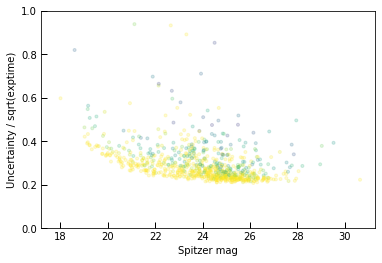

In [251]:
###########
# Save results to the model image and photometry file
model_image = '{0}-{1}_model.fits'.format(root, ch_label)
if os.path.exists(model_image):
    full_model = pyfits.open(model_image)[0].data
else:
    full_model = irac_im.data*0
    
full_model[isly, islx][msk2d] = h_model[msk2d]
pyfits.writeto(model_image, data=full_model, header=irac_im.header, overwrite=True)

ds9.frame(11)
ds9.view(full_model, header=irac_im.header)

# Fluxes and uncertainties from the least squares fit
flux = _x[0][Nbg:Nbg+N]*1
covar = np.matrix(np.dot(_Ax.T, _Ax)).I.A
err = np.sqrt(covar.diagonal())[Nbg:Nbg+N]

# Clip very negative measurements
bad = flux < -2*err
flux[bad] = 0.
err[bad] = 2*err[bad]

# Put ERR_SCALE in catalog header
phot.meta['{0}_ERR_SCALE'.format(column_root.upper())] = ERR_SCALE

if 'mips' not in column_root:
    phot['{0}_flux'.format(column_root)][ids-1] = flux
    phot['{0}_err'.format(column_root)][ids-1] = err
    nexp, expt = irac_psf_obj.get_exposure_time(phot['ra'], phot['dec'], verbose=True)
    phot['{0}_nexp'.format(column_root)] = nexp
    phot['{0}_exptime'.format(column_root)] = expt
else:

    phot['{0}_flux'.format(column_root)][ids-1] = flux*irac_psf_obj.apcorr
    phot['{0}_err'.format(column_root)][ids-1] = err*irac_psf_obj.apcorr

    phot['F325'] = phot['mips_24_flux']
    phot['E325'] = phot['mips_24_err']

if bright is not None:
    try:
        phot['{0}_bright'.format(column_root)][ids[bright]-1] = 1
    except:
        phot['{0}_bright'.format(column_root)] = 0
        phot['{0}_bright'.format(column_root)][ids[bright]-1] = 1

# Additional NNeighbors columns
if ('id_nn' not in phot.colnames) | True:

    pos = np.array([phot['ra'], phot['dec']]).T
    pos = (pos - np.median(pos,  axis=0))
    tree = scipy.spatial.cKDTree(pos)
    dn, nn = tree.query(pos, k=2)
    phot['dr_nn'] = dn[:,1]*3600*u.arcsec
    phot['dr_nn'].format = '.2f'

    phot['dmag_nn'] = phot['mag_auto'] - phot['mag_auto'][nn[:,1]]
    phot['dr_nn'].format = '.2f'

    phot['id_nn'] = phot['number'][nn[:,1]]

    plt.scatter(23.9-2.5*np.log10(flux), err*np.sqrt(expt[ids-1]/3600.), 
                alpha=0.2, c=phot['dr_nn'][ids-1], vmin=0, vmax=2) 
    plt.xlabel('Spitzer mag')
    plt.ylabel('Uncertainty / sqrt(exptime)')
    plt.ylim(0,1)
    
phot.write(f'{root}_irac_phot.fits', overwrite=True)

In [ ]:
####################################
# Model image with fully separate component layers

comp_file = f'{root}-{ch_label}_components.fits'
if os.path.exists(comp_file):
    comp_hdu = pyfits.open(comp_file)
else:
    comp_hdu = pyfits.HDUList([pyfits.PrimaryHDU(header=irac_im.header, data=full_mask)])
    comp_hdu[0].header['EXTNAME'] = 'MASK'
    full_mask = np.zeros(irac_im.data.shape, dtype=np.uint8)
    
full_mask[isly, islx] |= msk2d

wsl = irac_wcs.slice((isly, islx))  

# Slices for subcomponent models
yp, xp = np.indices(h_model.shape)
flux = _x[0][Nbg:Nbg+N]*1

SKIP = False

for i, id in enumerate(ids):
    extn = 'MODEL',id
    if (extn in comp_hdu) & SKIP:
        print(f'Extension ({extn}) exists, skip.')
        continue
        
    ix = ids == id
    _Ai = _A[ix,:].reshape(h_model.shape)

    nonz = _Ai/_Ai.max() > 1.e-6

    xpm = xp[nonz]
    ypm = yp[nonz]

    sislx = slice(xpm.min(), xpm.max())
    sisly = slice(ypm.min(), ypm.max())
    print(id, nonz.sum(), sislx, sisly)
    #print(islx, isly)
    
    sub_wcs = wsl.slice((sisly, sislx))
    sub_head = utils.to_header(sub_wcs)
    
    hdu_i = pyfits.ImageHDU(data=(_Ai*nonz*flux[i])[sisly, sislx], header=sub_head)
    
    hdu_i.header['ID'] = (id, 'Object ID number')
    hdu_i.header['EXTNAME'] = 'MODEL'
    hdu_i.header['EXTVER'] = id
    hdu_i.header['NPIX'] = nonz.sum()
    
    hdu_i.header['FLUX_UJY'] = (flux[i], 'Total flux density, uJy')
    hdu_i.header['ERR_UJY'] = (err[i], 'Total flux uncertainty, uJy')
    
    hdu_i.header['XMIN'] = (sislx.start + islx.start, 'x slice min')
    hdu_i.header['XMAX'] = (sislx.stop + islx.start, 'x slice max')
    hdu_i.header['YMIN'] = (sisly.start + isly.start, 'y slice min')
    hdu_i.header['YMAX'] = (sisly.stop + isly.start, 'y slice max')

    if ('MODEL',id) in comp_hdu:
        comp_hdu[extn] = hdu_i
    else:
        comp_hdu.append(hdu_i)

comp_hdu.writeto(comp_file, overwrite=True)

In [ ]:
# Do another patch if desired or switch filters and repeat above

## Refine morphological models with GALFIT (experimental)

In [243]:
from grizli.galfit import galfit
tf = None
use_psf = False # Use full subsampled PSF, doesn't help much and is slower
psf_offset, wpower = 0, -1
galfit_ids = []

In [248]:
fit_ids = [180, 181, 166, 200, 211]
fit_ids = [235]#, 121, 145]

fit_ids = [235]
if 0:
    # IDs that touch
    xid = 291
    xid = 139
    xmsk = (seg_sl == xid)
    msk_dil = binary_dilation(xmsk, np.ones((21,21)))
    fit_ids = list(np.unique(seg_sl[msk_dil])[1:])


In [249]:
wsl = irac_wcs.slice((isly, islx))  
head = utils.to_header(wsl)

components = [galfit.GalfitSky()]
segmap = (seg_sl == 0)[pf//2::pf,pf//2::pf]

segmap &= (sivar > 0).reshape(segmap.shape)
segmap &= b_conv.reshape(segmap.shape) < 0.1

_c = _x[0]*1.

_Af = np.vstack([_Abg, _A])  

dp = (Npan-32) #//2

pop_ids = []

flux = _x[0][Nbg:Nbg+N]*1

for id_i in fit_ids:
    ix = phot['number'] == id_i
    _c[Nbg + np.arange(len(ids))[ids == id_i]] = 0
    segmap |= (seg_sl[pf//2::pf,pf//2::pf] == id_i)
    if use_psf == 2:
        components += [galfit.GalfitPSF()]
    else:
        components += [galfit.GalfitSersic(q=0.8)]#, R_e=0.5)]

    xy = wsl.all_world2pix(np.array([phot['ra'][ix], phot['dec'][ix]]).T, 1).flatten()+0.5
    components[-1].pdict['pos'] = list(xy)
    components[-1].pdict['mag'] = 22.5
    if (id_i in ids) & True:
        components[-1].pdict['mag'] = 26.563-2.5*np.log10(np.maximum(flux[ids == id_i], 1))[0]
        
    try:
        components[-1].pdict['n'] = fixn
        components[-1].pfree['n'] = nfree
    except:
        pass
        
    if root == 'j094952p1707':
        if id_i in [202, 167]:
            components.pop(-1)
            pop_ids.append(id_i)
            continue
            
        if id_i == 111:
            components[-1].pdict['pos'] = [129, 74]
            components[-1].pdict['mag'] = 26
            components[-1].pfree['n'] = 0   
            components[-1].pdict['n'] = 1.
            
            # components[-1] = galfit.GalfitPSF()
            # components[-1].pdict['pos'] = [129, 74]
            # components[-1].pdict['mag'] = 25
                            
        if id_i == 137:
            components[-1].pdict['pos'] = [112, 74]
            components[-1].pdict['mag'] = 23
            components[-1].pfree['n'] = 0   
            components[-1].pdict['n'] = 1.5   
        if id_i == 134:
            components[-1].pdict['pos'] = [106, 73]
            components[-1].pdict['mag'] = 22.
        if id_i == 133:
            components[-1].pdict['pos'] = [118, 73]
            components[-1].pdict['mag'] = 22.
        if id_i == 125:
            components[-1].pdict['pos'] = [137, 74]
            components[-1].pdict['mag'] = 23.

        elif id_i in [121]:
            components.pop(-1)
            pop_ids.append(id_i)
            continue
            
    if root == 'xj094952p1707':
        # Manual recent
        
        if id_i == 129:
            components.pop(-1)
            pop_ids.append(id_i)
            continue
           
            components[-1].pdict['pos'] = [29+dp, 34+dp]
            components[-1].pdict['mag'] =  25
        elif id_i == 117:
            components[-1].pdict['pos'] = [33.3+dp, 33.9+dp]
            components[-1].pdict['mag'] = 22.8
        elif id_i == 121:
            components[-1].pdict['pos'] = [44.7+dp, 34.8+dp]
            components[-1].pdict['mag'] = 24.6
        elif id_i == 130:
            components[-1].pdict['pos'] = [26.0+dp, 33.8+dp]
            components[-1].pdict['mag'] = 22.6
            c#omponents[-1].pfree['n'] = 1   
        elif id_i in [133]:
            components.pop(-1)       
            pop_ids.append(id_i)
            continue
        elif id_i == 107:
            # The source
            components[-1].pdict['pos'] = [39.8+dp, 34.7+dp]
            components[-1].pdict['mag'] = 25
            #components[-1].output = 1
        
            #components[-1].pfree['pos'] = [0, 0]
            #components[-1].pfree['n'] = 0
    
        if id_i in [196, 190]:
            if (ch == 1) & (id_i == 196):
                continue
            
            components[-1].pfree['n'] = 1
        
for id in pop_ids:
    fit_ids.pop(fit_ids.index(id))
            
h_model = _Af.T.dot(_c).reshape(h_sm.shape)
ydata = irac_im.data[isly, islx] - h_model

ds9.frame(15)
ds9.view(ydata*segmap, header=head)

ivar = (irac_sivar[isly, islx])**2
ivar = 1/(1/ivar+(0.02*ydata)**2)

if use_psf == 1:
    gf = galfit.Galfitter.fit_arrays(ydata, ivar*segmap, segmap*1, irac_psf, psf_sample=5, id=1, components=components, recenter=False, exptime=0)
else:
    gf = galfit.Galfitter.fit_arrays(ydata, ivar*segmap, segmap*1, irac_psf[pf//2::pf,pf//2::pf], psf_sample=1, id=1, components=components, recenter=False, exptime=0)

ds9.frame(15)
ds9.view(gf['resid'].data*segmap, header=head)

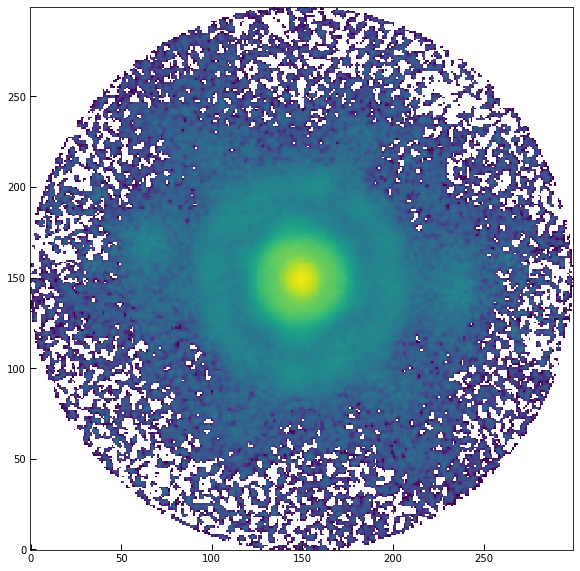

In [242]:
fig = plt.figure(figsize=[10, 10])
plt.imshow(np.log10(irac_psf), vmin=-7, vmax=-2.5)
plt.savefig('/tmp/ch2_round_psf.png')

In [250]:
# Is the FIT OK? Replace it in the model matrix
galfit_ids += fit_ids

# Component imaage
cwd = os.getcwd()
os.chdir('/tmp/')
os.system('perl -pi -e "s/P\) 0/P\) 3/" gf.gfmodel')
os.system('galfit gf.gfmodel')
im = pyfits.open('subcomps.fits')

os.chdir(cwd)
for i, id in enumerate(fit_ids):
    gf_model = im[i+2].data.flatten()
    _A[ids == id,:] = gf_model/gf_model.sum()

# 
_Af = np.vstack([_Abg, _A])  

# Bright stars
if bright is not None:
    h_bright = _A[bright,:].T.dot(Anorm[bright])
else:
    h_bright = 0

msk = sivar > 0
msk &= h_bright*sivar < bright_sn
msk &= b_conv < 0.1
msk2d = msk.reshape(h_sm.shape)

_Ax = (_Af[:,msk]*sivar[msk]).T
_yx = (y*sivar)[msk]

#bad = ~np.isfinite(_Ax)
print('Least squares')

_x = np.linalg.lstsq(_Ax, _yx, rcond=-1)

h_model = _Af.T.dot(_x[0]).reshape(h_sm.shape)

ds9.view(msk2d*(irac_im.data[isly, islx]-h_model), header=utils.get_wcs_slice_header(irac_wcs, islx, isly))


Least squares


In [329]:
####################################
# Model image with fully separate component layers

comp_file = f'{root}-{ch_label}_components.fits'
if os.path.exists(comp_file):
    comp_hdu = pyfits.open(comp_file)
else:
    comp_hdu = pyfits.HDUList([pyfits.PrimaryHDU(header=irac_im.header, data=full_mask)])
    comp_hdu[0].header['EXTNAME'] = 'MASK'
    full_mask = np.zeros(irac_im.data.shape, dtype=np.uint8)
    
full_mask[isly, islx] |= msk2d

wsl = irac_wcs.slice((isly, islx))  

# Slices for subcomponent models
yp, xp = np.indices(h_model.shape)
flux = _x[0][Nbg:Nbg+N]*1

SKIP = False

for i, id in enumerate(ids):
    extn = 'MODEL',id
    if (extn in comp_hdu) & SKIP:
        print(f'Extension ({extn}) exists, skip.')
        continue
        
    ix = ids == id
    _Ai = _A[ix,:].reshape(h_model.shape)

    nonz = _Ai/_Ai.max() > 1.e-6

    xpm = xp[nonz]
    ypm = yp[nonz]

    sislx = slice(xpm.min(), xpm.max())
    sisly = slice(ypm.min(), ypm.max())
    print(id, nonz.sum(), sislx, sisly)
    #print(islx, isly)
    
    sub_wcs = wsl.slice((sisly, sislx))
    sub_head = utils.to_header(sub_wcs)
    
    hdu_i = pyfits.ImageHDU(data=(_Ai*nonz*flux[i])[sisly, sislx], header=sub_head)
    
    hdu_i.header['ID'] = (id, 'Object ID number')
    hdu_i.header['EXTNAME'] = 'MODEL'
    hdu_i.header['EXTVER'] = id
    hdu_i.header['NPIX'] = nonz.sum()
    
    hdu_i.header['FLUX_UJY'] = (flux[i], 'Total flux density, uJy')
    hdu_i.header['ERR_UJY'] = (err[i], 'Total flux uncertainty, uJy')
    
    hdu_i.header['XMIN'] = (sislx.start + islx.start, 'x slice min')
    hdu_i.header['XMAX'] = (sislx.stop + islx.start, 'x slice max')
    hdu_i.header['YMIN'] = (sisly.start + isly.start, 'y slice min')
    hdu_i.header['YMAX'] = (sisly.stop + isly.start, 'y slice max')

    if ('MODEL',id) in comp_hdu:
        comp_hdu[extn] = hdu_i
    else:
        comp_hdu.append(hdu_i)

comp_hdu.writeto(comp_file, overwrite=True)

Extension (('MODEL', 8)) exists, skip.
Extension (('MODEL', 9)) exists, skip.
Extension (('MODEL', 10)) exists, skip.
Extension (('MODEL', 11)) exists, skip.
Extension (('MODEL', 12)) exists, skip.
Extension (('MODEL', 13)) exists, skip.
Extension (('MODEL', 14)) exists, skip.
Extension (('MODEL', 15)) exists, skip.
Extension (('MODEL', 16)) exists, skip.
Extension (('MODEL', 17)) exists, skip.
Extension (('MODEL', 18)) exists, skip.
Extension (('MODEL', 19)) exists, skip.
Extension (('MODEL', 20)) exists, skip.
Extension (('MODEL', 21)) exists, skip.
Extension (('MODEL', 22)) exists, skip.
Extension (('MODEL', 23)) exists, skip.
Extension (('MODEL', 24)) exists, skip.
Extension (('MODEL', 25)) exists, skip.
Extension (('MODEL', 26)) exists, skip.
Extension (('MODEL', 27)) exists, skip.
Extension (('MODEL', 28)) exists, skip.
Extension (('MODEL', 29)) exists, skip.
Extension (('MODEL', 30)) exists, skip.
Extension (('MODEL', 31)) exists, skip.
Extension (('MODEL', 32)) exists, skip.
Ex

Extension (('MODEL', 227)) exists, skip.
Extension (('MODEL', 228)) exists, skip.
Extension (('MODEL', 229)) exists, skip.
Extension (('MODEL', 230)) exists, skip.
Extension (('MODEL', 231)) exists, skip.
Extension (('MODEL', 232)) exists, skip.
Extension (('MODEL', 233)) exists, skip.
Extension (('MODEL', 234)) exists, skip.
Extension (('MODEL', 235)) exists, skip.
Extension (('MODEL', 236)) exists, skip.
Extension (('MODEL', 237)) exists, skip.
Extension (('MODEL', 238)) exists, skip.
Extension (('MODEL', 239)) exists, skip.
Extension (('MODEL', 240)) exists, skip.
Extension (('MODEL', 241)) exists, skip.
Extension (('MODEL', 242)) exists, skip.
Extension (('MODEL', 243)) exists, skip.
Extension (('MODEL', 244)) exists, skip.
Extension (('MODEL', 245)) exists, skip.
Extension (('MODEL', 246)) exists, skip.
Extension (('MODEL', 247)) exists, skip.
Extension (('MODEL', 248)) exists, skip.
Extension (('MODEL', 249)) exists, skip.
Extension (('MODEL', 250)) exists, skip.
Extension (('MOD

Extension (('MODEL', 434)) exists, skip.
Extension (('MODEL', 435)) exists, skip.
Extension (('MODEL', 436)) exists, skip.
Extension (('MODEL', 437)) exists, skip.
Extension (('MODEL', 438)) exists, skip.
Extension (('MODEL', 439)) exists, skip.
Extension (('MODEL', 440)) exists, skip.
Extension (('MODEL', 441)) exists, skip.
Extension (('MODEL', 442)) exists, skip.
Extension (('MODEL', 443)) exists, skip.
Extension (('MODEL', 444)) exists, skip.
Extension (('MODEL', 445)) exists, skip.
Extension (('MODEL', 446)) exists, skip.
Extension (('MODEL', 447)) exists, skip.
Extension (('MODEL', 448)) exists, skip.
Extension (('MODEL', 449)) exists, skip.
Extension (('MODEL', 450)) exists, skip.
Extension (('MODEL', 451)) exists, skip.
Extension (('MODEL', 452)) exists, skip.
Extension (('MODEL', 453)) exists, skip.
Extension (('MODEL', 454)) exists, skip.
Extension (('MODEL', 455)) exists, skip.
Extension (('MODEL', 456)) exists, skip.
Extension (('MODEL', 457)) exists, skip.
Extension (('MOD

Extension (('MODEL', 636)) exists, skip.
Extension (('MODEL', 637)) exists, skip.
Extension (('MODEL', 638)) exists, skip.
Extension (('MODEL', 639)) exists, skip.
Extension (('MODEL', 640)) exists, skip.
Extension (('MODEL', 641)) exists, skip.
Extension (('MODEL', 642)) exists, skip.
Extension (('MODEL', 643)) exists, skip.
Extension (('MODEL', 645)) exists, skip.
Extension (('MODEL', 646)) exists, skip.
Extension (('MODEL', 647)) exists, skip.
Extension (('MODEL', 648)) exists, skip.
Extension (('MODEL', 649)) exists, skip.
Extension (('MODEL', 650)) exists, skip.
Extension (('MODEL', 651)) exists, skip.
Extension (('MODEL', 652)) exists, skip.
Extension (('MODEL', 653)) exists, skip.
Extension (('MODEL', 654)) exists, skip.
Extension (('MODEL', 655)) exists, skip.
Extension (('MODEL', 656)) exists, skip.
Extension (('MODEL', 657)) exists, skip.
Extension (('MODEL', 658)) exists, skip.
Extension (('MODEL', 659)) exists, skip.
Extension (('MODEL', 660)) exists, skip.
Extension (('MOD

Extension (('MODEL', 845)) exists, skip.
Extension (('MODEL', 846)) exists, skip.
Extension (('MODEL', 847)) exists, skip.
Extension (('MODEL', 848)) exists, skip.
Extension (('MODEL', 849)) exists, skip.
Extension (('MODEL', 850)) exists, skip.
Extension (('MODEL', 851)) exists, skip.
Extension (('MODEL', 852)) exists, skip.
Extension (('MODEL', 853)) exists, skip.
Extension (('MODEL', 854)) exists, skip.
Extension (('MODEL', 855)) exists, skip.
Extension (('MODEL', 856)) exists, skip.
Extension (('MODEL', 857)) exists, skip.
Extension (('MODEL', 858)) exists, skip.
Extension (('MODEL', 859)) exists, skip.
Extension (('MODEL', 860)) exists, skip.
Extension (('MODEL', 861)) exists, skip.
Extension (('MODEL', 862)) exists, skip.
Extension (('MODEL', 863)) exists, skip.
Extension (('MODEL', 864)) exists, skip.
Extension (('MODEL', 865)) exists, skip.
Extension (('MODEL', 866)) exists, skip.
Extension (('MODEL', 867)) exists, skip.
Extension (('MODEL', 868)) exists, skip.
Extension (('MOD